In [2]:
# 👆 Put this at the very top of your notebook
%matplotlib inline
import matplotlib.pyplot as plt


Shape: (1000, 16)

Columns: ['student_id', 'age', 'gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation', 'exam_score']

Missing Values:
 student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

Dataset Summary:
        student_id        age  gender  

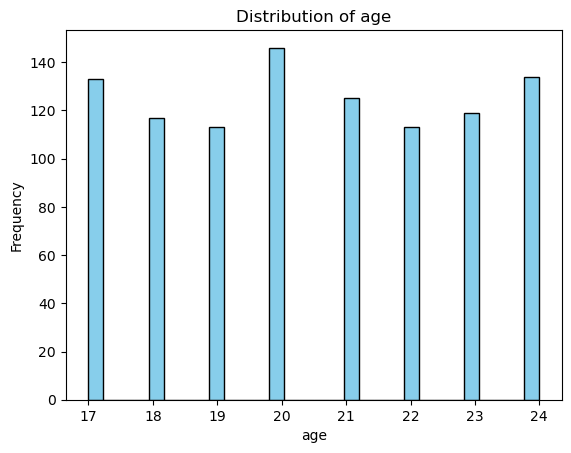

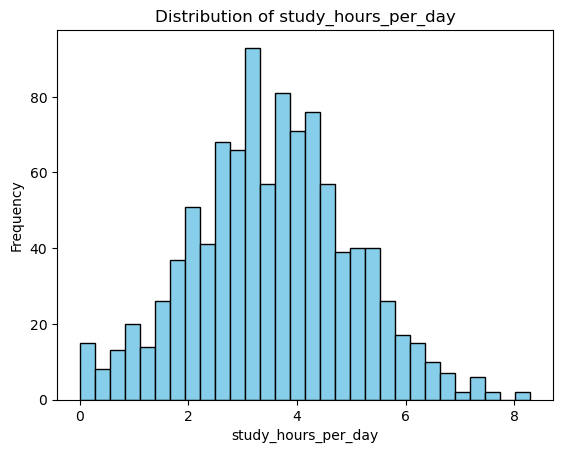

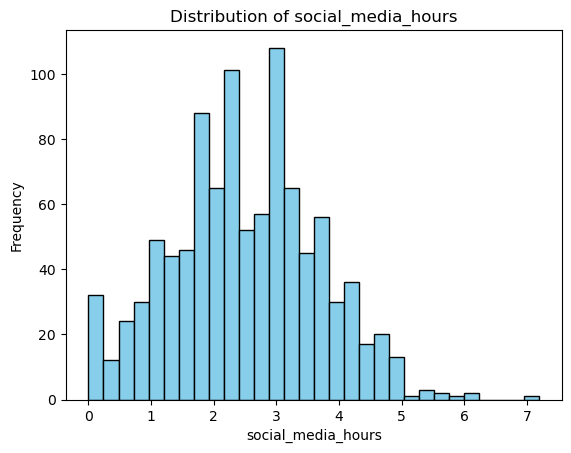

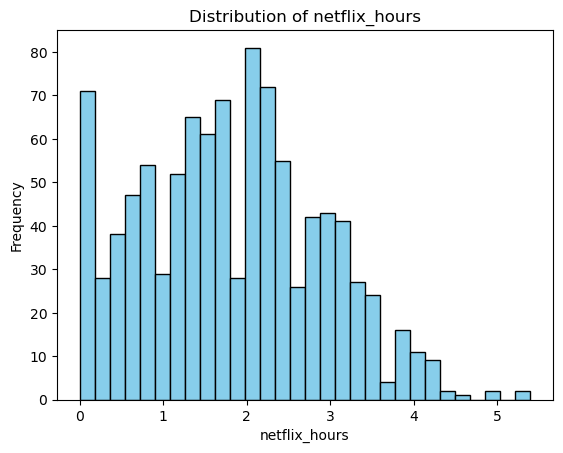

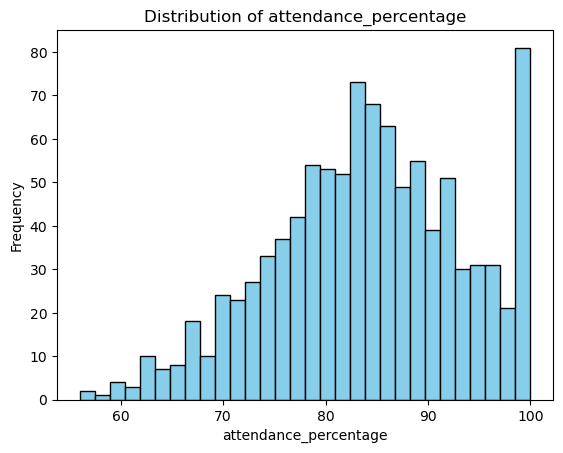

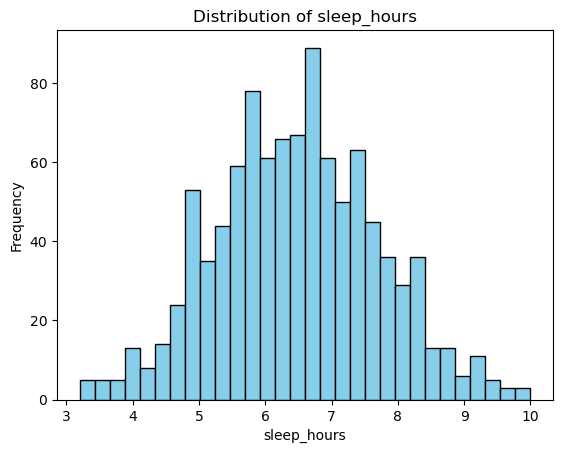

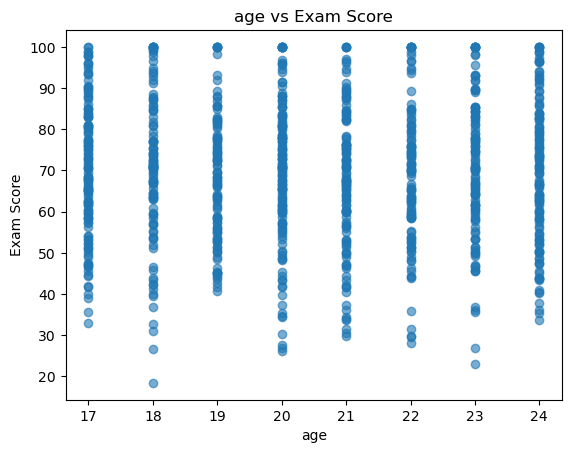

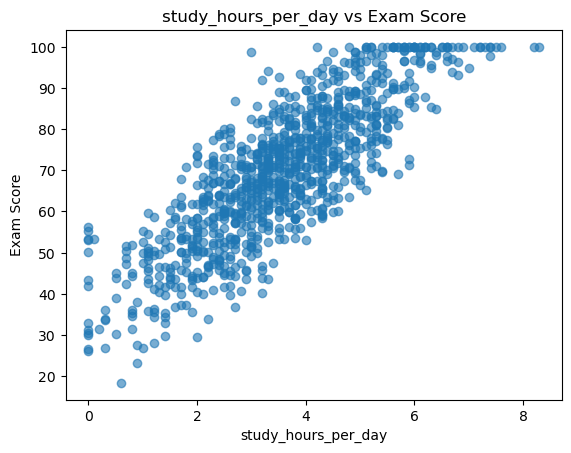

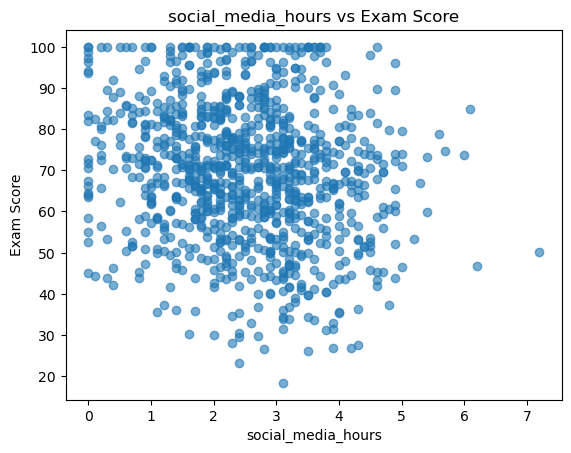

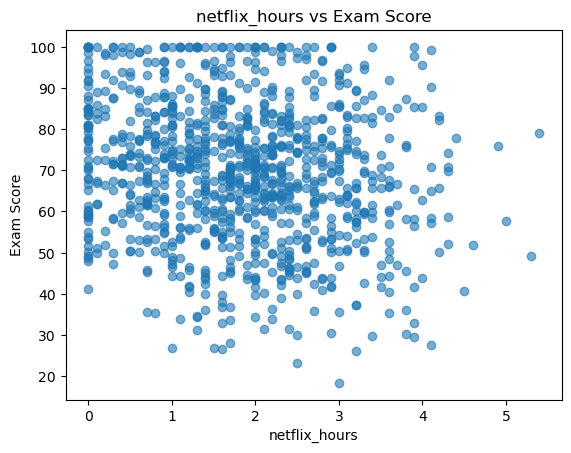

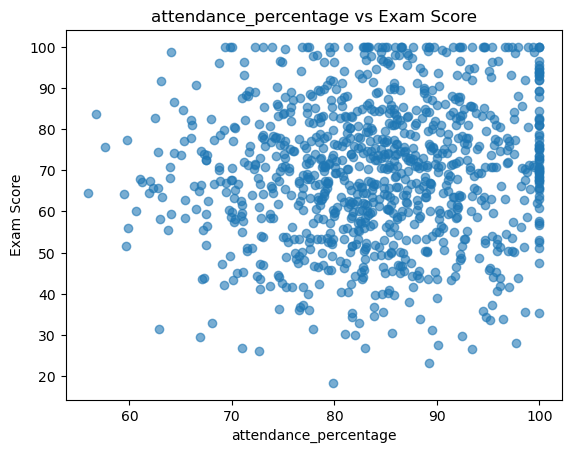

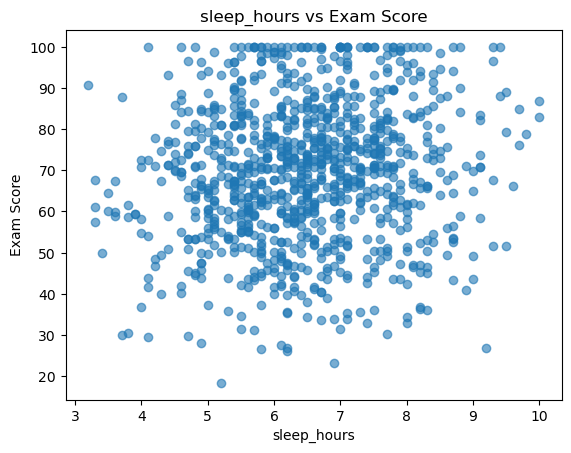

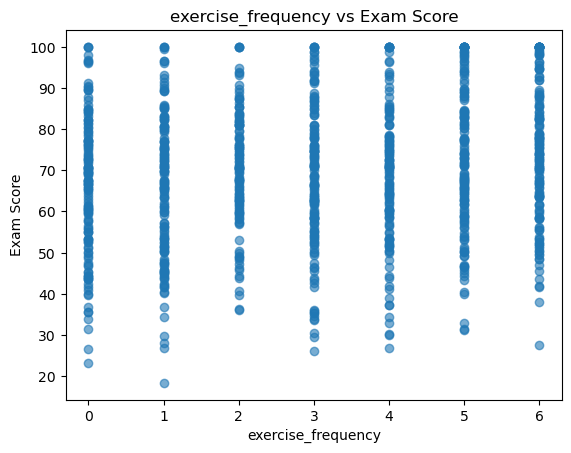

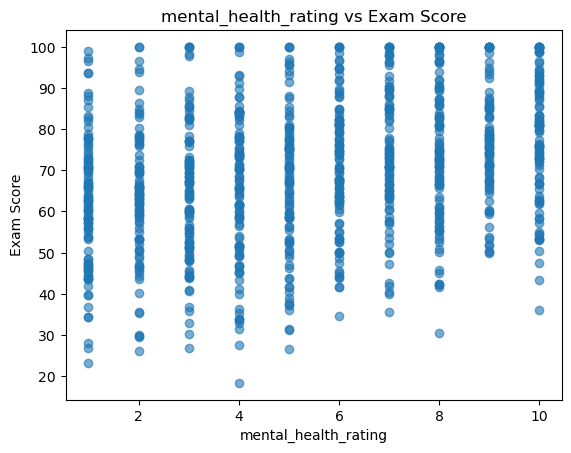

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

FILE = r"C:\Data\student_habits_performance.csv"
df = pd.read_csv(FILE)

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isna().sum())

# Summary statistics
print("\nDataset Summary:\n", df.describe(include='all'))

# Example distributions
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols[:6]:
    plt.figure()
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Scatter vs target
if "exam_score" in df.columns:
    for col in numeric_cols:
        if col != "exam_score":
            plt.figure()
            plt.scatter(df[col], df["exam_score"], alpha=0.6)
            plt.xlabel(col)
            plt.ylabel("Exam Score")
            plt.title(f"{col} vs Exam Score")
            plt.show()


In [2]:
import pandas as pd

FILE = r"C:\Data\student_habits_performance.csv"
df = pd.read_csv(FILE)

# Add new meaningful features
df["leisure_hours"] = df["social_media_hours"] + df["netflix_hours"]
df["study_sleep_ratio"] = df["study_hours_per_day"] / df["sleep_hours"]
df["sleep_deficit"] = (8 - df["sleep_hours"]).clip(lower=0)
df["attendance_x_study"] = df["attendance_percentage"] * df["study_hours_per_day"]

print(df[["leisure_hours", "study_sleep_ratio", "sleep_deficit", "attendance_x_study"]].head())
df.to_csv(r"C:\Data\student_habits_engineered.csv", index=False)


   leisure_hours  study_sleep_ratio  sleep_deficit  attendance_x_study
0            2.3           0.000000            0.0                0.00
1            5.1           1.500000            3.4              671.37
2            4.4           0.175000            0.0              132.72
3            4.9           0.108696            0.0               71.00
4            4.9           1.020408            3.1              454.50


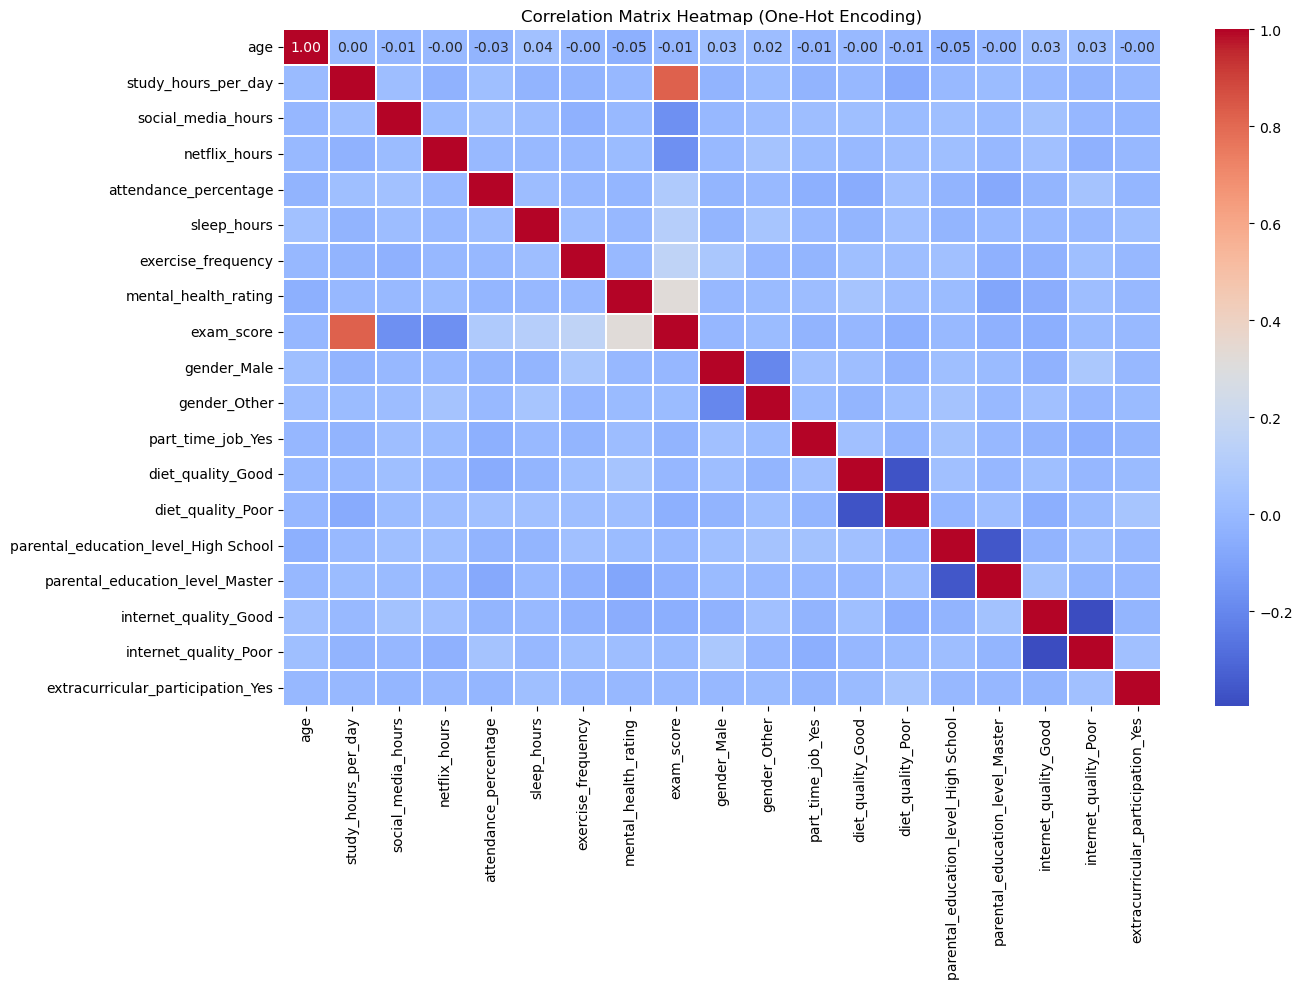

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dataset ---
FILE = r"C:\Data\student_habits_performance.csv"
df = pd.read_csv(FILE)

# --- Drop unique or irrelevant columns ---
df = df.drop(columns=["student_id"], errors="ignore")

# --- One-Hot Encode categorical data ---
df_encoded = pd.get_dummies(df, drop_first=True)

# --- Compute correlation matrix ---
corr = df_encoded.corr()

# --- Plot clean heatmap ---
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.3,
    cbar=True
)
plt.title("Correlation Matrix Heatmap (One-Hot Encoding)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


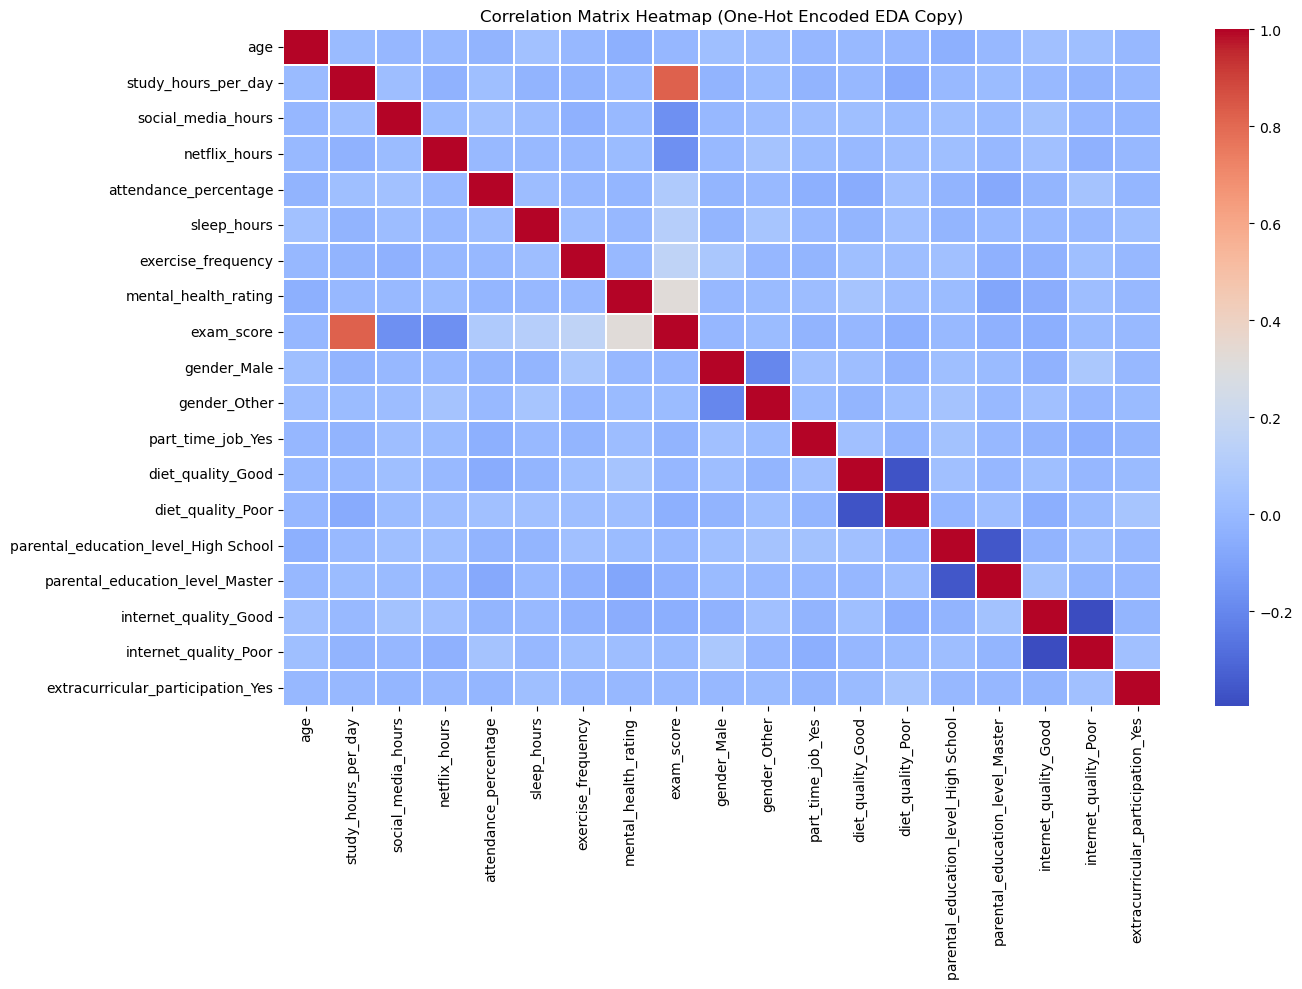

Training and test data prepared.
X_train shape: (800, 14) | X_test shape: (200, 14)

Linear Regression (with pipeline) -> R²: 0.8965 | MAE: 4.19 | RMSE: 5.15


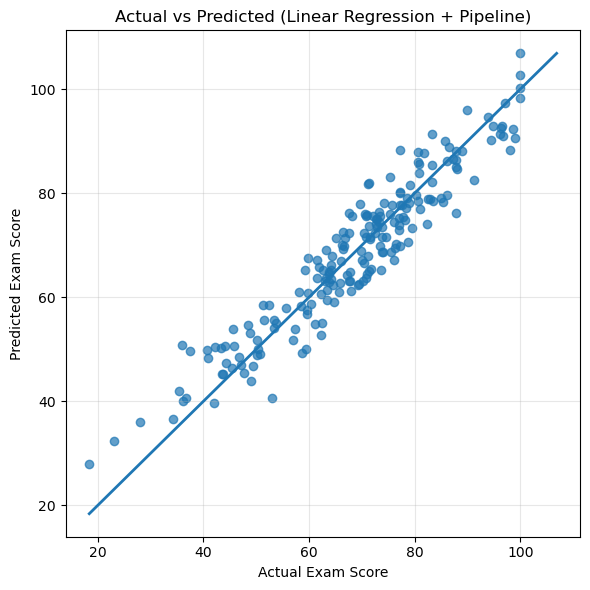


Total transformed features: 18
Example transformed feature names: ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating', 'gender_Male', 'gender_Other', 'part_time_job_Yes', 'diet_quality_Good', 'diet_quality_Poor', 'parental_education_level_High School', 'parental_education_level_Master']


In [10]:
# ================================================================
# CONNECTED EDA + PREPROCESSING PIPELINE
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# -----------------------------
# 1) Load dataset once
# -----------------------------
FILE = r"C:\Data\student_habits_performance.csv"
df = pd.read_csv(FILE)

# Drop unique/irrelevant id column if present
df = df.drop(columns=["student_id"], errors="ignore")

# -----------------------------
# 2) QUICK EDA: Correlation heatmap with one-hot encoded copy
#    (keeps your seaborn heatmap)
# -----------------------------
# Create an encoded copy for EDA ONLY (do not reuse this for modeling pipeline)
df_eda = pd.get_dummies(df, drop_first=True)

corr = df_eda.corr(numeric_only=True)  # ensures only numeric correlation
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,        # set True if you want numbers; False is cleaner for big matrices
    fmt=".2f",
    linewidths=0.3,
    cbar=True
)
plt.title("Correlation Matrix Heatmap (One-Hot Encoded EDA Copy)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# -----------------------------
# 3) TARGET / FEATURES for modeling
# -----------------------------
target = "exam_score"
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found. Available: {df.columns.tolist()}")

X = df.drop(columns=[target])
y = df[target]

# Identify numeric/categorical cols for pipeline
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

# -----------------------------
# 4) Preprocessing pipeline (impute + scale + one-hot)
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# -----------------------------
# 5) Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print("Training and test data prepared.")
print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")

# -----------------------------
# 6) Optional: quick model to verify end-to-end
#    (You can remove this if you only want preprocessing.)
# -----------------------------
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("linreg", LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=True) ** 0.5

print(f"\nLinear Regression (with pipeline) -> R²: {r2:.4f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")

# -----------------------------
# 7) Actual vs Predicted plot (nice quick sanity check)
# -----------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
min_v, max_v = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], lw=2)
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Actual vs Predicted (Linear Regression + Pipeline)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 8) (Optional) See the final feature names after one-hot encoding
# -----------------------------
def get_feature_names_after_preprocessor(preprocessor, numeric_cols, categorical_cols):
    names = []
    # numeric names pass through scaler unchanged
    names.extend(numeric_cols)
    # categorical names come from the encoder
    try:
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
    except Exception:
        # fallback in case older sklearn
        # fit a sample to get shape, then create generic names
        cat_sample = preprocessor.named_transformers_["cat"].named_steps["onehot"].fit_transform(
            X[categorical_cols].fillna("MISSING")
        )
        cat_names = [f"cat_{i}" for i in range(cat_sample.shape[1])]
    names.extend(cat_names)
    return names

# Fit preprocessor on all X (to extract feature names)
preprocessor.fit(X)
final_feature_names = get_feature_names_after_preprocessor(preprocessor, numeric_features, categorical_features)
print(f"\nTotal transformed features: {len(final_feature_names)}")
print("Example transformed feature names:", final_feature_names[:15])


 Shape: (1000, 16)

 Data Types:
 student_id                        object
age                                int64
gender                            object
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                     object
attendance_percentage            float64
sleep_hours                      float64
diet_quality                      object
exercise_frequency                 int64
parental_education_level          object
internet_quality                  object
mental_health_rating               int64
extracurricular_participation     object
exam_score                       float64
dtype: object

 Missing Values:
 parental_education_level         91
student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job            

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4



 Categorical Features (unique value counts):
  student_id: 1000 unique
  gender: 3 unique
  part_time_job: 2 unique
  diet_quality: 3 unique
  parental_education_level: 3 unique
  internet_quality: 3 unique
  extracurricular_participation: 2 unique


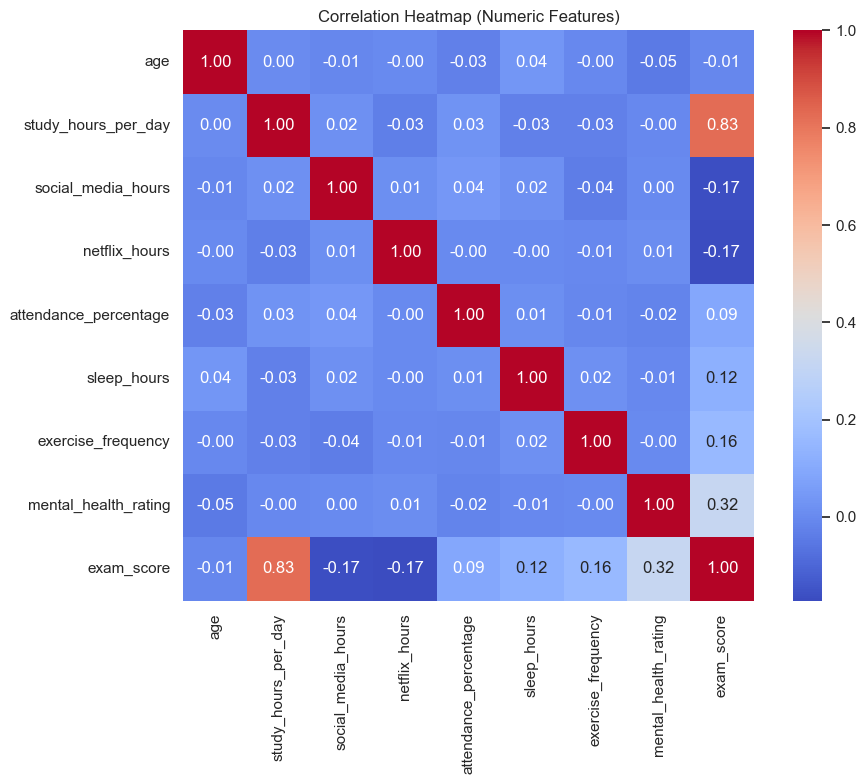

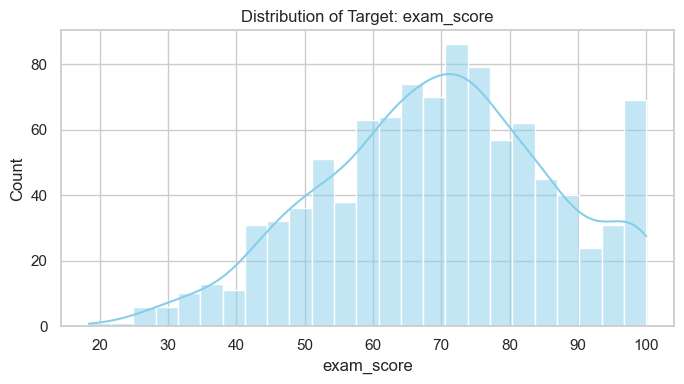


 Top correlated numeric features with target:
study_hours_per_day      0.825419
mental_health_rating     0.321523
exercise_frequency       0.160107
sleep_hours              0.121683
attendance_percentage    0.089836
Name: exam_score, dtype: float64


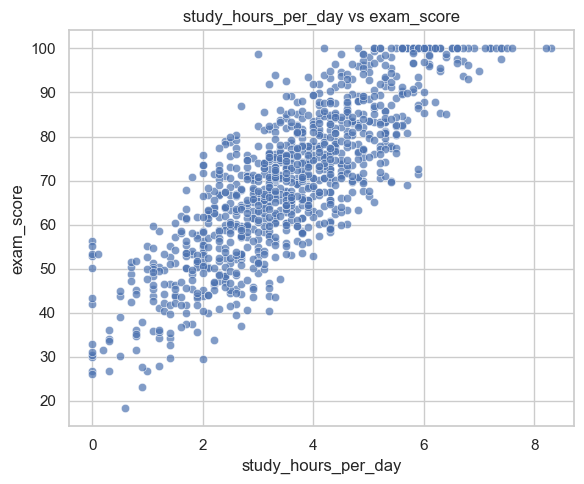

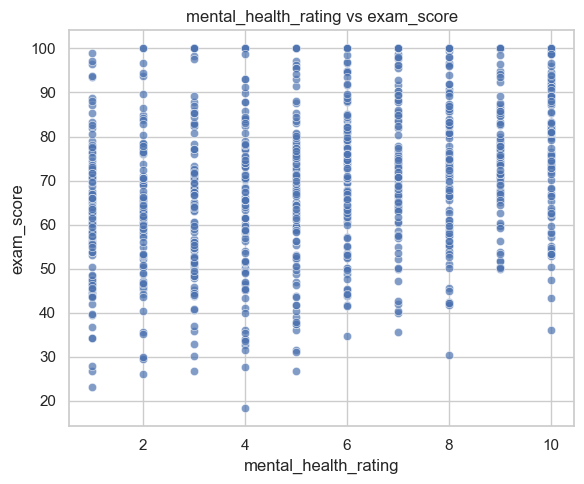

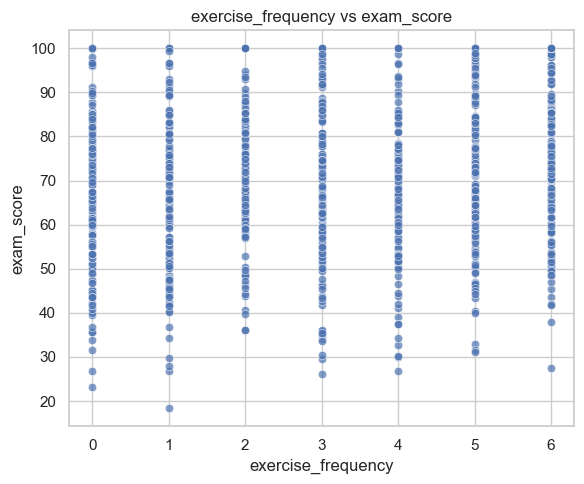

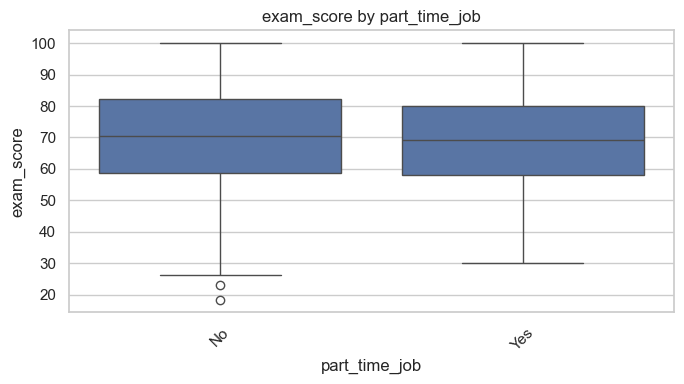

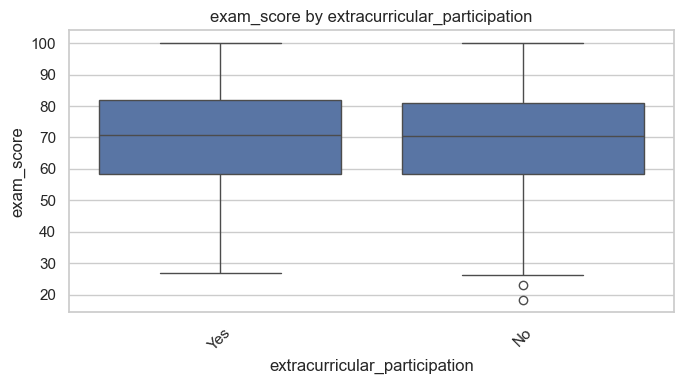

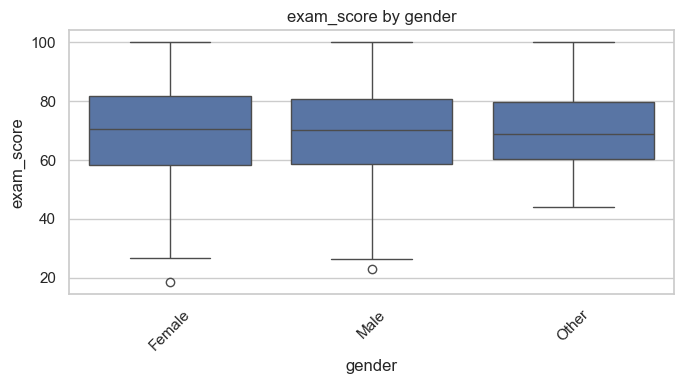

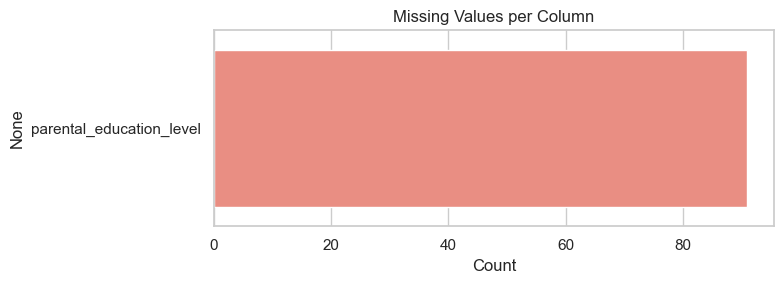


 EDA completed successfully!


In [1]:
#Exploratory Data Analysis (EDA)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# 1️. Config
CSV_PATH = r"C:\Data\student_habits_performance.csv"  
TARGET   = "exam_score"                          

# 2. Load Dataset

df = pd.read_csv(CSV_PATH)

print(" Shape:", df.shape)
print("\n Data Types:\n", df.dtypes)
print("\n Missing Values:\n", df.isnull().sum().sort_values(ascending=False))

# 3️. Summary Statistics

num_df = df.select_dtypes(include=['number'])
print("\n Summary Statistics (numeric):\n", num_df.describe().T)

# Display first few rows
try:
    from IPython.display import display
    display(df.head())
except:
    print(df.head())


# 4️. Categorical Feature Overview

cat_cols = [c for c in df.columns if df[c].dtype == 'object' or str(df[c].dtype).startswith('category')]
if cat_cols:
    print("\n Categorical Features (unique value counts):")
    for c in cat_cols:
        print(f"  {c}: {df[c].nunique()} unique")

# 5️. Correlation Heatmap (Numeric Only)
if num_df.shape[1] >= 2:
    corr = num_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", square=True)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()

# 6️. Target Variable Distribution
if TARGET in df.columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[TARGET].dropna(), kde=True, bins=25, color="skyblue")
    plt.title(f"Distribution of Target: {TARGET}")
    plt.xlabel(TARGET); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print(f" Target column '{TARGET}' not found for distribution plot.")

# 7️. Top Correlated Features with Target
if TARGET in num_df.columns:
    target_corr = (
        num_df.corr()[TARGET]
        .drop(labels=[TARGET])
        .sort_values(ascending=False)
    )
    print("\n Top correlated numeric features with target:")
    print(target_corr.head(5))
    
    # Plot top 3 correlations
    top_feats = list(target_corr.head(3).index)
    for feat in top_feats:
        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=df[feat], y=df[TARGET], alpha=0.7)
        plt.title(f"{feat} vs {TARGET}")
        plt.tight_layout()
        plt.show()

# 8️. Target vs Categorical Features (Boxplots)
top_cats = sorted(cat_cols, key=lambda c: df[c].nunique())[:3]
for c in top_cats:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x=df[c], y=df[TARGET])
    plt.title(f"{TARGET} by {c}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 9️. Missing Values (Bar Plot)
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if not missing.empty:
    plt.figure(figsize=(8, max(3, 0.3 * len(missing))))
    sns.barplot(x=missing.values, y=missing.index, color="salmon")
    plt.title("Missing Values per Column")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

print("\n EDA completed successfully!")



Duplicate rows: 0 (0.00%)
Shape: (1000, 15)

Data Types:
 age                                int64
gender                            object
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                     object
attendance_percentage            float64
sleep_hours                      float64
diet_quality                      object
exercise_frequency                 int64
parental_education_level          object
internet_quality                  object
mental_health_rating               int64
extracurricular_participation     object
exam_score                       float64
dtype: object

Missing Values:
 age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_q

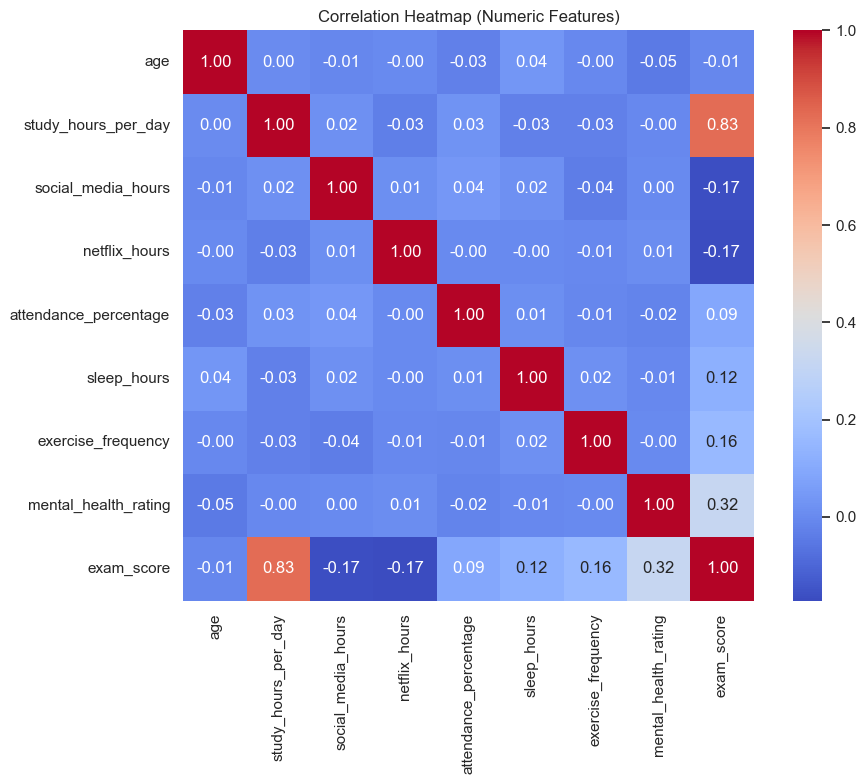

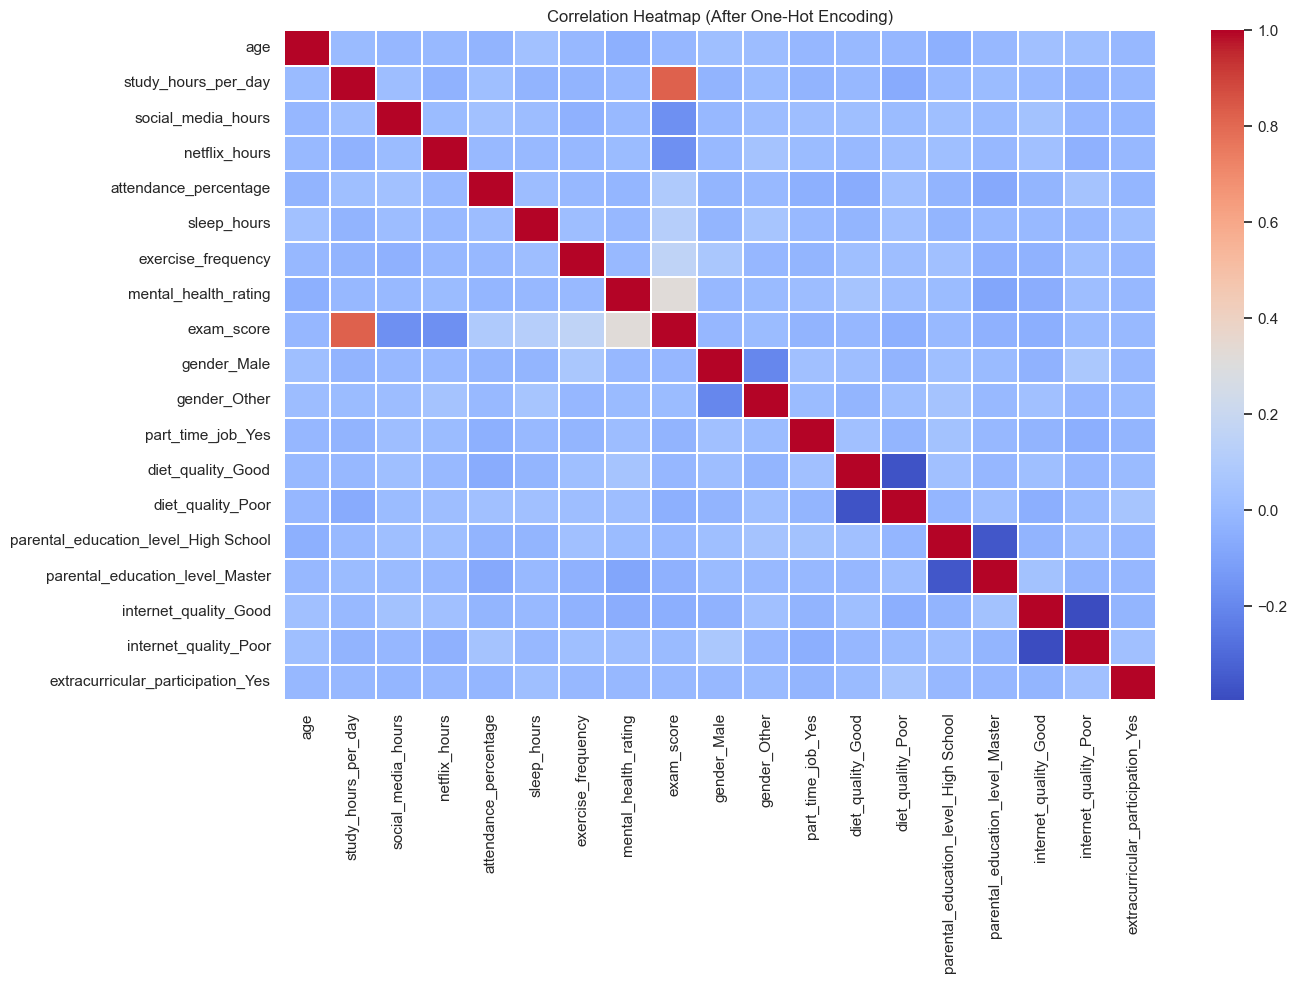

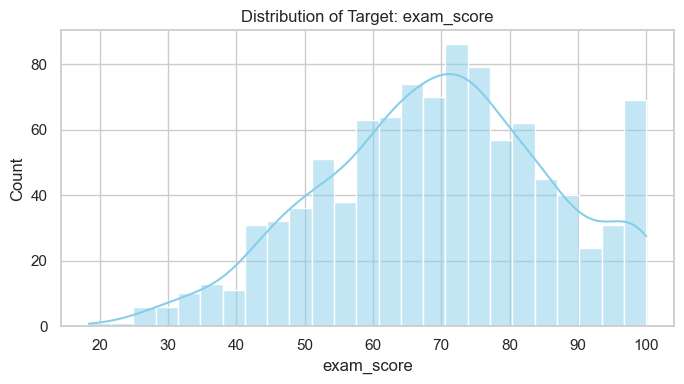


Top correlated numeric features with target:
study_hours_per_day      0.825419
mental_health_rating     0.321523
exercise_frequency       0.160107
sleep_hours              0.121683
attendance_percentage    0.089836
Name: exam_score, dtype: float64


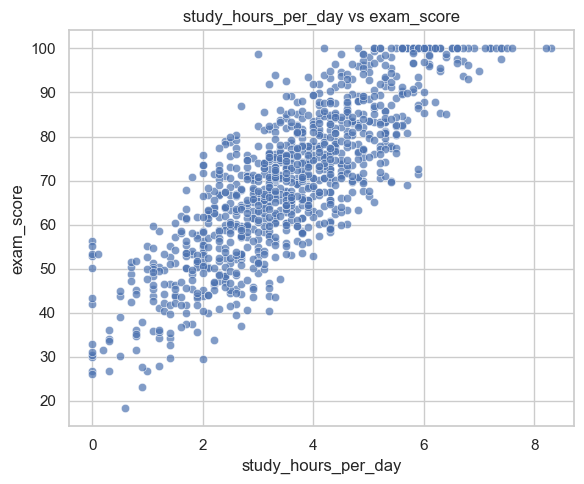

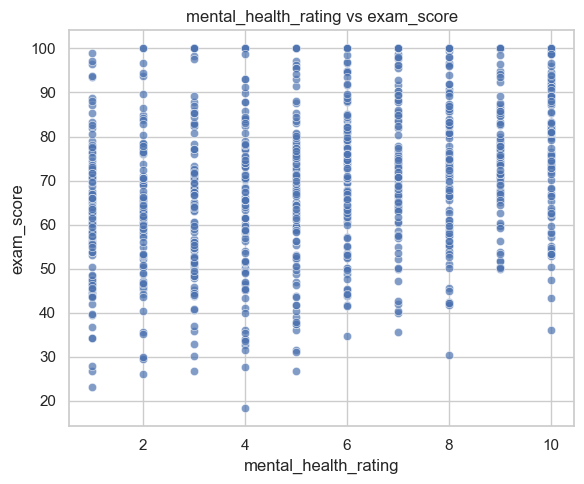

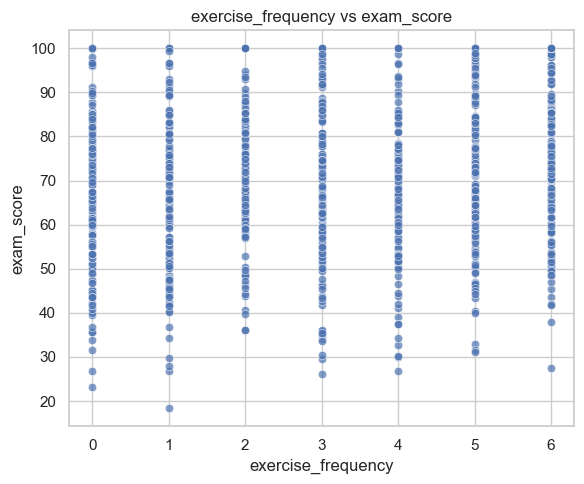

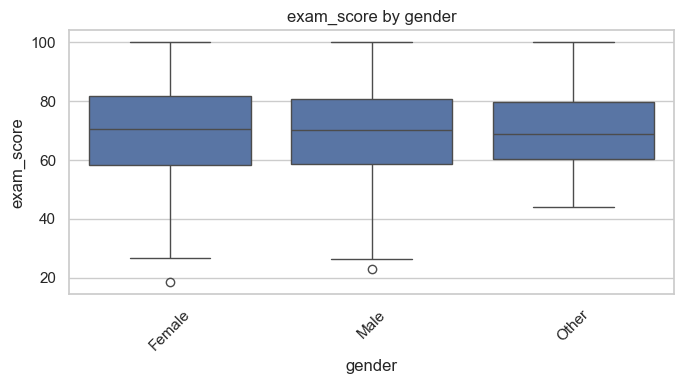

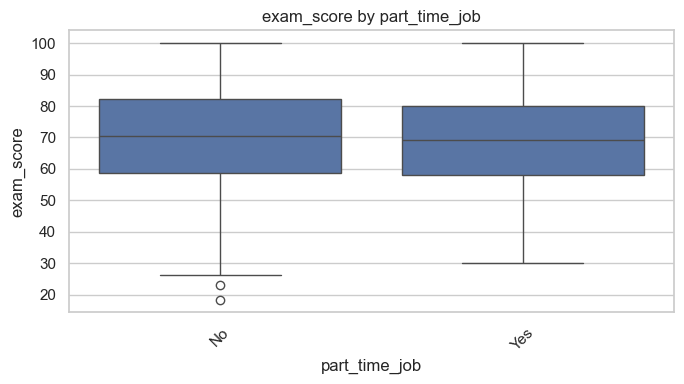

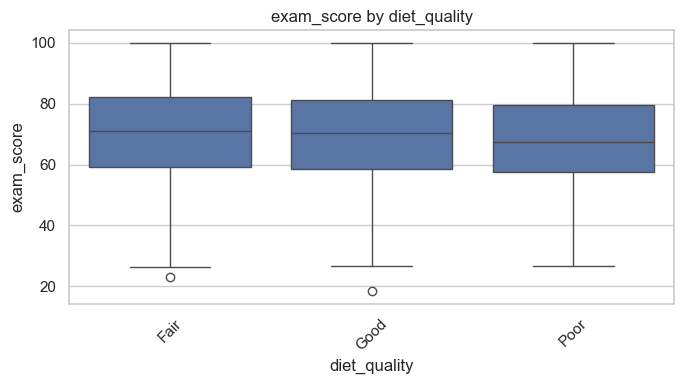

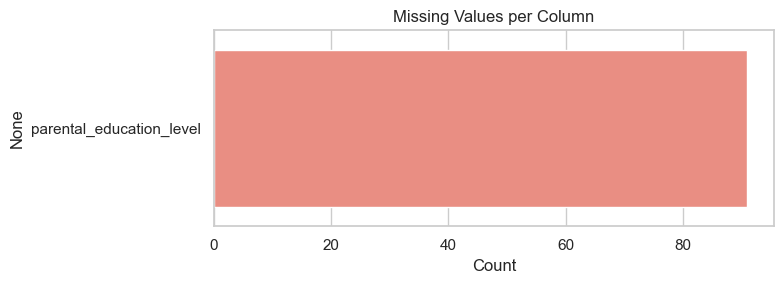


EDA completed successfully — numeric & encoded heatmaps generated.


In [6]:
# Exploratory Data Analysis (EDA) - Combined Numeric & Encoded Heatmaps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# 1) Config
CSV_PATH = r"C:\Data\student_habits_performance.csv"
TARGET = "exam_score"

# 2) Load Dataset
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=["student_id"], errors="ignore")  # Drop irrelevant ID if exists

# 2b) Duplicates Check (and optional removal)
DROP_DUPLICATES = True 
dup_count = df.duplicated().sum()
dup_pct = 100 * dup_count / len(df) if len(df) else 0
print(f"\nDuplicate rows: {dup_count} ({dup_pct:.2f}%)")

if DROP_DUPLICATES and dup_count > 0:
    df_before = len(df)
    df = df.drop_duplicates(ignore_index=True)
    print(f"Dropped {df_before - len(df)} duplicate rows. New shape: {df.shape}")

print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

# 3) Summary Statistics
num_df = df.select_dtypes(include=['number'])
print("\nSummary Statistics:\n", num_df.describe().T)

# 4) Correlation Heatmap (Numeric Only)
if num_df.shape[1] >= 2:
    plt.figure(figsize=(10, 8))
    corr_numeric = num_df.corr()
    sns.heatmap(corr_numeric, cmap="coolwarm", annot=True, fmt=".2f", square=True)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()

# 5) One-Hot Encoded Correlation Heatmap
# Encode categorical columns for extended correlation analysis
df_encoded = pd.get_dummies(df, drop_first=True)
corr_encoded = df_encoded.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_encoded, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.3, cbar=True)
plt.title("Correlation Heatmap (After One-Hot Encoding)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6) Target Distribution
if TARGET in df.columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[TARGET].dropna(), kde=True, bins=25, color="skyblue")
    plt.title(f"Distribution of Target: {TARGET}")
    plt.xlabel(TARGET)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# 7) Top Correlated Features with Target
if TARGET in num_df.columns:
    target_corr = num_df.corr()[TARGET].drop(TARGET).sort_values(ascending=False)
    print("\nTop correlated numeric features with target:")
    print(target_corr.head(5))
    
    top_feats = list(target_corr.head(3).index)
    for feat in top_feats:
        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=df[feat], y=df[TARGET], alpha=0.7)
        plt.title(f"{feat} vs {TARGET}")
        plt.tight_layout()
        plt.show()

# 8) Target vs Categorical Features (Boxplots)
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
if cat_cols:
    for c in cat_cols[:3]:  # Limit to top 3 categorical features
        plt.figure(figsize=(7, 4))
        sns.boxplot(x=df[c], y=df[TARGET])
        plt.title(f"{TARGET} by {c}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 9) Missing Values (Bar Plot)
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if not missing.empty:
    plt.figure(figsize=(8, max(3, 0.3 * len(missing))))
    sns.barplot(x=missing.values, y=missing.index, color="salmon")
    plt.title("Missing Values per Column")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values detected.")

print("\nEDA completed successfully — numeric & encoded heatmaps generated.")



 Feature engineering added successfully:
   leisure_hours  study_sleep_ratio  sleep_deficit  attendance_x_study
0            2.3           0.000000            0.0                0.00
1            5.1           1.500000            3.4              671.37
2            4.4           0.175000            0.0              132.72
3            4.9           0.108696            0.0               71.00
4            4.9           1.020408            3.1              454.50
Engineered dataset saved to: C:\Data\student_habits_engineered.csv
Best Ridge Parameter: {'alpha': 0.001}

Test Metrics
Ridge Regression       -> MAE: 4.2639 | RMSE: 5.2138 | R²: 0.8940
ANN (Deep Learning)    -> MAE: 4.5336 | RMSE: 5.5863 | R²: 0.8783
Hybrid (Ridge + ANN)   -> MAE: 4.2769 | RMSE: 5.2313 | R²: 0.8933
Chosen alpha (weight on Ridge) for hybrid: 0.85


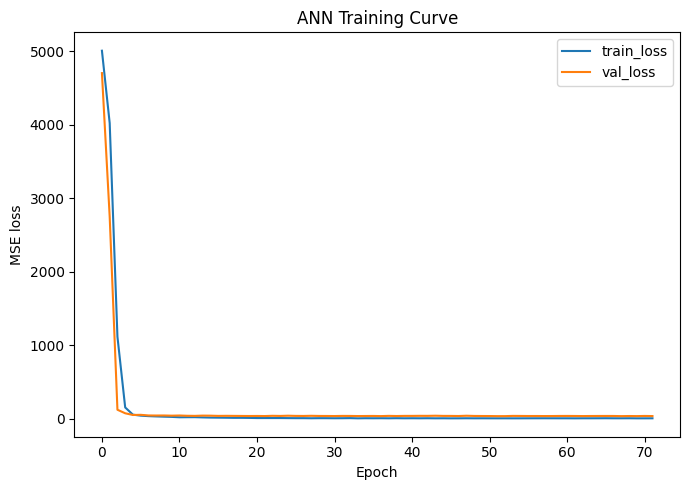

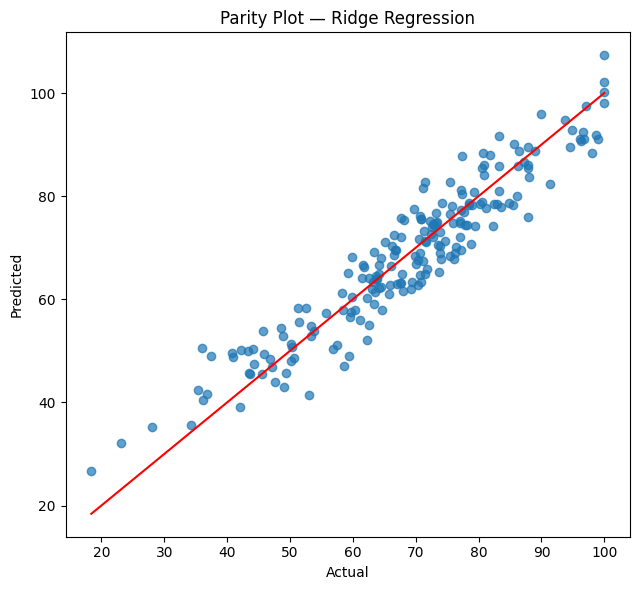

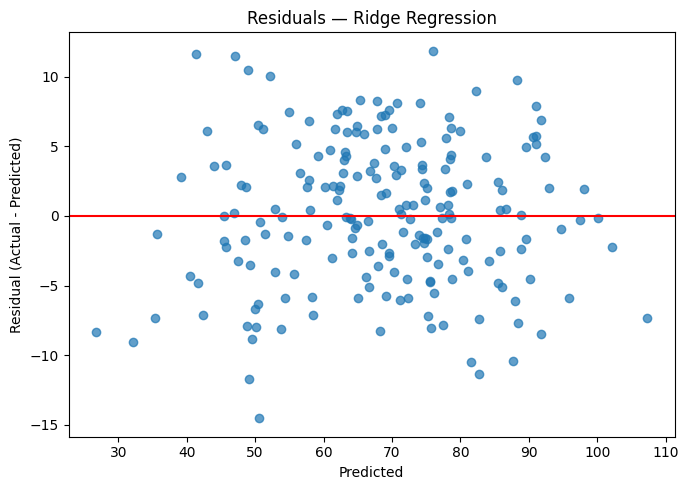

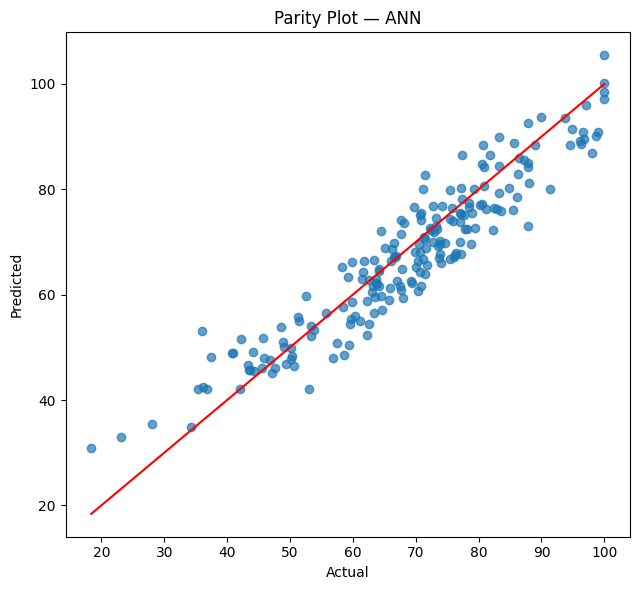

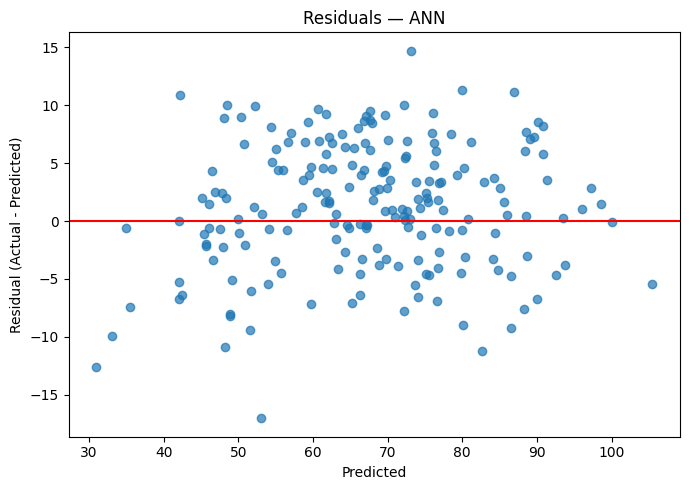

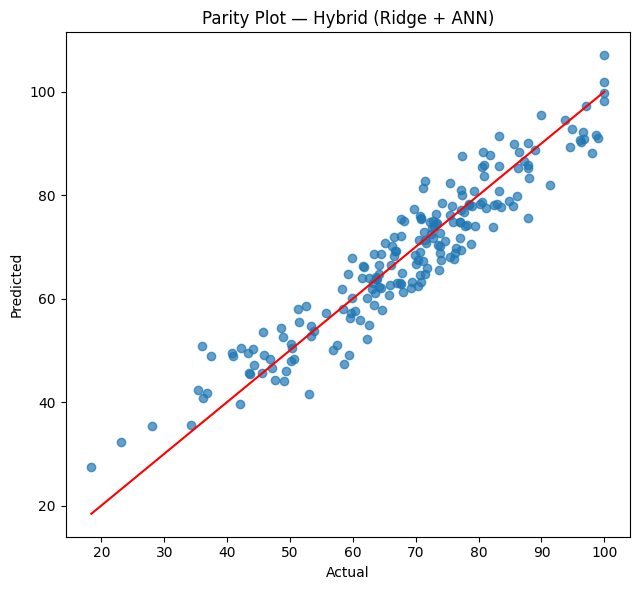

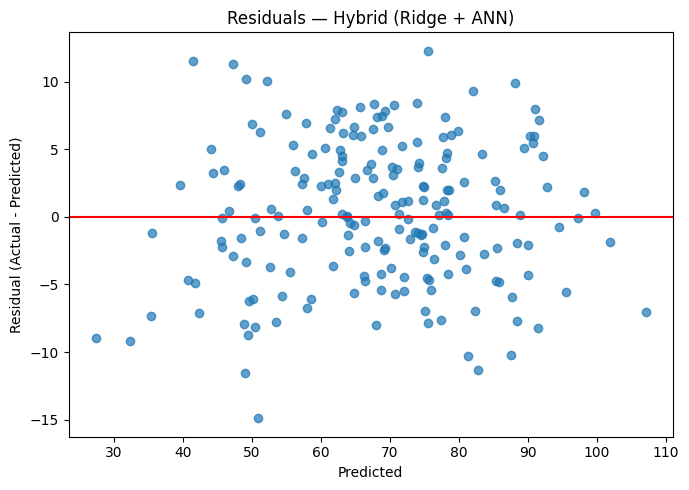

In [4]:
# Regression: Traditional (Ridge), Deep (ANN), Hybrid (Ridge + ANN)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep learning
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1) Config
CSV_PATH = r"C:\Data\student_habits_performance.csv" 
ENGINEERED_PATH = r"C:\Data\student_habits_engineered.csv"
TARGET   = "exam_score"                

RANDOM_STATE = 42
TEST_SIZE    = 0.2
VAL_SIZE     = 0.2
EPOCHS       = 200
BATCH_SIZE   = 32        
PATIENCE     = 20

# 2) Load data
df = pd.read_csv(CSV_PATH)

if TARGET not in df.columns:
    raise ValueError(f"TARGET column '{TARGET}' not found. Columns: {list(df.columns)}")

# ===== Feature Engineering Section =====
if all(col in df.columns for col in ["social_media_hours", "netflix_hours", "study_hours_per_day", "sleep_hours", "attendance_percentage"]):
    df["leisure_hours"] = df["social_media_hours"] + df["netflix_hours"]
    df["study_sleep_ratio"] = df["study_hours_per_day"] / df["sleep_hours"]
    df["sleep_deficit"] = (8 - df["sleep_hours"]).clip(lower=0)
    df["attendance_x_study"] = df["attendance_percentage"] * df["study_hours_per_day"]

    print("\n Feature engineering added successfully:")
    print(df[["leisure_hours", "study_sleep_ratio", "sleep_deficit", "attendance_x_study"]].head())
    df.to_csv(ENGINEERED_PATH, index=False)
    print(f"Engineered dataset saved to: {ENGINEERED_PATH}")
else:
    print(" Skipping feature engineering — required columns not found in dataset.")

# ======================================

# Separate features/target
y = df[TARGET].astype(float)
X = df.drop(columns=[TARGET])

# Identify feature types
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('category')]
num_cols = [c for c in X.columns if c not in cat_cols]

# 3) Train/Validation/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train, test_size=VAL_SIZE, random_state=RANDOM_STATE
)

# 4) Preprocessing
num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

preprocessor.fit(X_fit)

X_fit_t = preprocessor.transform(X_fit)
X_val_t = preprocessor.transform(X_val)
X_train_t = preprocessor.transform(X_train)
X_test_t = preprocessor.transform(X_test)
input_dim = X_train_t.shape[1]

# 5) Ridge Regression
param_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
ridge = Ridge(max_iter=5000, random_state=RANDOM_STATE)
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_fit_t, y_fit)

best_ridge = grid_search.best_estimator_
print(f"Best Ridge Parameter: {grid_search.best_params_}")

ridge_val_pred  = best_ridge.predict(X_val_t)
ridge_test_pred = best_ridge.predict(X_test_t)

# 6) ANN (Deep Learning)
def build_ann(input_dim: int):
    model = Sequential([
        Input(shape=(input_dim,)),    # clean Input layer — avoids warning
        Dense(128, activation="relu"),
        Dropout(0.10),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

ann = build_ann(input_dim)
early_stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
history = ann.fit(
    X_fit_t, y_fit,
    validation_data=(X_val_t, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[early_stop]
)

ann_val_pred  = ann.predict(X_val_t, verbose=0).flatten()
ann_test_pred = ann.predict(X_test_t, verbose=0).flatten()

# 7) Hybrid (Ridge + ANN)
alphas = np.linspace(0, 1, 101)
best_alpha, best_mse = None, np.inf
for a in alphas:
    blend = a * ridge_val_pred + (1 - a) * ann_val_pred
    mse = mean_squared_error(y_val, blend)
    if mse < best_mse:
        best_mse, best_alpha = mse, a

hyb_test_pred = best_alpha * ridge_test_pred + (1 - best_alpha) * ann_test_pred

# 8) Metrics
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2  = r2_score(y_true, y_pred)
    return mae, rmse, r2

ridge_mae,  ridge_rmse,  ridge_r2  = metrics(y_test, ridge_test_pred)
ann_mae, ann_rmse, ann_r2 = metrics(y_test, ann_test_pred)
hyb_mae, hyb_rmse, hyb_r2 = metrics(y_test, hyb_test_pred)

print("\nTest Metrics")
print(f"Ridge Regression       -> MAE: {ridge_mae:.4f} | RMSE: {ridge_rmse:.4f} | R²: {ridge_r2:.4f}")
print(f"ANN (Deep Learning)    -> MAE: {ann_mae:.4f} | RMSE: {ann_rmse:.4f} | R²: {ann_r2:.4f}")
print(f"Hybrid (Ridge + ANN)   -> MAE: {hyb_mae:.4f} | RMSE: {hyb_rmse:.4f} | R²: {hyb_r2:.4f}")
print(f"Chosen alpha (weight on Ridge) for hybrid: {best_alpha:.2f}")

# 9) Plots
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("ANN Training Curve")
plt.legend()
plt.tight_layout()
plt.show()

def parity_plot(y_true, y_pred, title):
    plt.figure(figsize=(6.5,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    mn, mx = np.min(y_true), np.max(y_true)
    plt.plot([mn, mx], [mn, mx], color="red")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def residuals_plot(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(7,5))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='red')
    plt.xlabel("Predicted")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plots for each model
parity_plot(y_test, ridge_test_pred, "Parity Plot — Ridge Regression")
residuals_plot(y_test, ridge_test_pred, "Residuals — Ridge Regression")

parity_plot(y_test, ann_test_pred, "Parity Plot — ANN")
residuals_plot(y_test, ann_test_pred, "Residuals — ANN")

parity_plot(y_test, hyb_test_pred, "Parity Plot — Hybrid (Ridge + ANN)")
residuals_plot(y_test, hyb_test_pred, "Residuals — Hybrid (Ridge + ANN)")
